In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transformer_train = []

augmenting_method = [transforms.RandomHorizontalFlip(),
                     transforms.RandomRotation(10),
                     transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                     transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),]
N = len(augmenting_method)

for i in range(N):
    transformer_train.append(transforms.Compose([transforms.Resize((32, 32)),
                                               augmenting_method[i],
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                            ]))

transformer = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])
training_loader = []
for i in range(N):
    training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformer_train[i])
    training_loader.append(torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True))

validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformer)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  image = image.clip(0, 1)
  return image

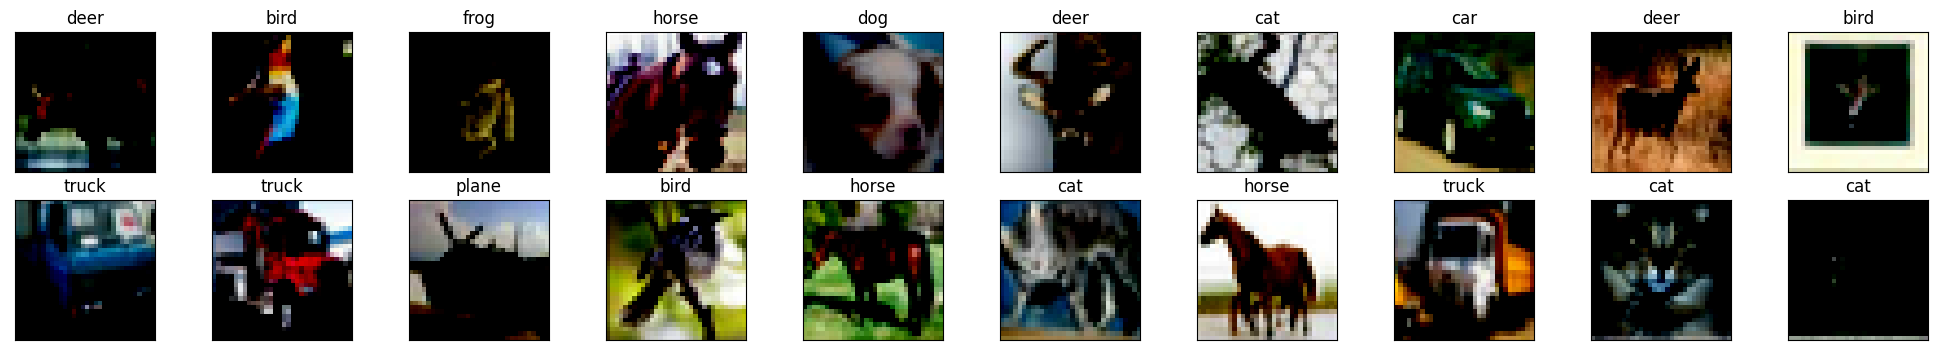

In [6]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

dataiter = iter(training_loader[0])
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))

for i in np.arange(20):
  # row 2 column 10
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[i]))
  ax.set_title(classes[labels[i].item()])

In [7]:
class Net(nn.Module):

  def __init__(self):
    super().__init__()
    # 32px 이었다가, conv를 거치면서 절반으로 감소
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [8]:
model = []
for _ in range(N):
    augmented_model = Net().to(device)
    model.append(augmented_model)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = []
for i in range(N):
    optimizer.append(torch.optim.Adam(model[i].parameters(), lr=0.001))

In [10]:
def train(device, model, criterion, optimizer, training_loader, validation_loader):
  epochs = 12
  running_loss_history = []
  running_correct_history = []
  validation_running_loss_history = []
  validation_running_correct_history = []

  for e in range(epochs):

    running_loss = 0.0
    running_correct = 0.0
    validation_running_loss = 0.0
    validation_running_correct = 0.0

    for inputs, labels in training_loader:

      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs, 1)

      running_correct += torch.sum(preds == labels.data)
      running_loss += loss.item()



    else:
      # 훈련팔 필요가 없으므로 메모리 절약
      with torch.no_grad():

        for val_input, val_label in validation_loader:

          val_input = val_input.to(device)
          val_label = val_label.to(device)
          val_outputs = model(val_input)
          val_loss = criterion(val_outputs, val_label)

          _, val_preds = torch.max(val_outputs, 1)
          validation_running_loss += val_loss.item()
          validation_running_correct += torch.sum(val_preds == val_label.data)


      epoch_loss = running_loss / len(training_loader)
      epoch_acc = running_correct.float() / len(training_loader)
      running_loss_history.append(epoch_loss)
      running_correct_history.append(epoch_acc)

      val_epoch_loss = validation_running_loss / len(validation_loader)
      val_epoch_acc = validation_running_correct.float() / len(validation_loader)
      validation_running_loss_history.append(val_epoch_loss)
      validation_running_correct_history.append(val_epoch_acc)

      print("===================================================")
      print("epoch: ", e + 1)
      print("training loss: {:.5f}, acc: {:5f}".format(epoch_loss, epoch_acc))
      print("validation loss: {:.5f}, acc: {:5f}".format(val_epoch_loss, val_epoch_acc))

In [11]:
for i in range(N):
    train(device, model[i], criterion, optimizer[i], training_loader[i], validation_loader)
    torch.save(model[i].state_dict(), f'cifar10_weights_{augmenting_method[i].__class__.__name__}.pth')

epoch:  1
training loss: 1.57827, acc: 42.156002
validation loss: 1.31667, acc: 52.230000
epoch:  2
training loss: 1.21724, acc: 56.120003
validation loss: 1.13047, acc: 58.840000
epoch:  3
training loss: 1.06276, acc: 62.026005
validation loss: 1.02869, acc: 63.619999
epoch:  4
training loss: 0.94674, acc: 66.448006
validation loss: 0.96677, acc: 65.820000
epoch:  5
training loss: 0.87707, acc: 69.134003
validation loss: 0.87143, acc: 69.869995
epoch:  6
training loss: 0.82104, acc: 71.200005
validation loss: 0.87408, acc: 69.500000
epoch:  7
training loss: 0.77485, acc: 72.828003
validation loss: 0.82967, acc: 71.479996
epoch:  8
training loss: 0.73223, acc: 74.326004
validation loss: 0.82295, acc: 71.589996
epoch:  9
training loss: 0.70819, acc: 75.126007
validation loss: 0.79992, acc: 72.750000
epoch:  10
training loss: 0.67281, acc: 76.366005
validation loss: 0.79001, acc: 73.029999
epoch:  11
training loss: 0.64549, acc: 77.212006
validation loss: 0.78174, acc: 73.139999
epoch:  